In [46]:
!pip install torchsummary
!pip install torchgeometry

In [47]:
!pip install albumentations

In [48]:
from torchsummary import summary
from torchgeometry.losses import one_hot
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import time
import imageio
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision.transforms import Resize, PILToTensor, ToPILImage, Compose, InterpolationMode
from collections import OrderedDict
import wandb

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose, OneOf
from albumentations.augmentations.transforms import RandomGamma

In [49]:
# import tensorflow as tf
# from tensorflow.compat.v1 import InteractiveSession

# tf.keras.backend.clear_session()
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [50]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d0d6e30c-cf77-7ca0-5871-f813fa4ed38a)
GPU 1: Tesla T4 (UUID: GPU-32deceac-4214-62f9-ae6f-02b63feeb9d3)


In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [52]:
# Number of class in the data set (3: neoplastic, non neoplastic, background)
num_classes = 3

# Number of epoch
epochs = 30

# Hyperparameters for training 
learning_rate = 2e-04
batch_size = 4
display_step = 50

# Model path
checkpoint_path = '/kaggle/working/unet_model.pth'
pretrained_path = "/kaggle/input/unet-checkpoint/unet_model.pth"
# Initialize lists to keep track of loss and accuracy
loss_epoch_array = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []

In [53]:
class TrainTransform:
    def __init__(self):
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomGamma(gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
            A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
            A.OneOf([A.Blur(), A.GaussianBlur(), A.GlassBlur(), A.MotionBlur(),
                    A.GaussNoise(), A.Sharpen(), A.MedianBlur(), A.MultiplicativeNoise()]),
            A.CoarseDropout(p=0.2, max_height=35, max_width=35, fill_value=255),
            A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.15, brightness_coeff=1.5, p=0.09),
            A.RandomShadow(p=0.1),
            A.ShiftScaleRotate(p=0.45, border_mode=cv2.BORDER_CONSTANT, shift_limit=0.15, scale_limit=0.15),
            A.Resize(256, 256, interpolation=cv2.INTER_LINEAR),
            A.Normalize(),
            ToTensorV2(),
        ])

    def __call__(self, img, mask):
        return self.transform(image=img, mask=mask)


class ValTransform:
    def __init__(self):
        self.transform = A.Compose([
            A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])
    def __call__(self, img, mask):
        return self.transform(image=img, mask=mask)


class TestTransform:
    def __init__(self):
        self.transform = A.Compose([
            A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])
    def __call__(self, img):
        return self.transform(image=img)['image']

In [54]:
# class UnetDataClass(Dataset):
#     def __init__(self, image_dir,mask_dir = [],mode = "train"):
#         super(UnetDataClass, self).__init__()
#         self.mode = mode
#         if mode == "train":
#             self.train_path = image_dir
#             self.train_mask_path = mask_dir
#             self.len = len(self.train_path)
#             self.train_transform = TrainTransform()
#         elif mode == "valid":
#             self.val_path = image_dir
#             self.val_mask_path = mask_dir
#             self.len = len(self.val_path)
#             self.val_transform = ValTransform()
#         elif mode == "test":
#             self.test_path = image_dir
#             self.len = len(self.test_path)
#             self.test_transform = TestTransform()

            
#     def read_mask(self, mask_path):
#         image = cv2.imread(mask_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
#         image = cv2.resize(image, (256,256))
#         # lower boundary RED color range values; Hue (0 - 10)
#         lower1 = np.array([0, 100, 20])
#         upper1 = np.array([10, 255, 255])
#         # upper boundary RED color range values; Hue (160 - 180)
#         lower2 = np.array([160, 100, 20])
#         upper2 = np.array([179, 255, 255])
#         lower_mask = cv2.inRange(image, lower1, upper1)
#         upper_mask = cv2.inRange(image, lower2, upper2)

#         red_mask = lower_mask + upper_mask
#         red_mask[red_mask != 0] = 1

#         # boundary GREEN color range values; Hue (36 - 70)
#         green_mask = cv2.inRange(image, (36, 25, 25), (70, 255, 255))
#         green_mask[green_mask != 0] = 2

#         full_mask = cv2.bitwise_or(red_mask, green_mask)
#         full_mask = full_mask.astype(np.uint8)
#         return full_mask


#     def __getitem__(self, index: int):
#         if self.mode == "train":
#             image = cv2.imread(self.train_path[index])
#             image = cv2.resize(image, (256,256))
#             mask = self.read_mask(self.train_mask_path[index])
#             return self.train_transform(image, mask)
#         elif self.mode == "valid":
#             image = cv2.imread(self.val_path[index])
#             image = cv2.resize(image, (256,256))
#             mask = self.read_mask(self.val_mask_path[index])
#             return self.val_transform(image, mask)
#         elif self.mode == "test":
#             image = cv2.imread(self.test_path[index])
#             H, W, _ = image.shape
#             image = cv2.resize(image, (256,256))
#             image = self.test_transform(image)
            
#             file_name = self.test_path[index].split('/')[-1].split('.')[0]
#             return  image, file_name,H, W
        
#     def __len__(self):
#         return self.len

In [55]:
class UnetDataClass(Dataset):
    def __init__(self, image_dir, transform, mask_dir = [],  mode = "train"):
        super(UnetDataClass, self).__init__()
        self.mode = mode
        if mode == "train":
            self.train_path = image_dir
            self.train_mask_path = mask_dir
            self.len = len(self.train_path)
            self.train_transform = transform
        elif mode == "valid":
            self.val_path = image_dir
            self.val_mask_path = mask_dir
            self.len = len(self.val_path)
            self.val_transform = transform
        elif mode == "test":
            self.test_path = image_dir
            self.len = len(self.test_path)
            self.test_transform = transform

            
    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        image = cv2.resize(image, (256,256))
        # lower boundary RED color range values; Hue (0 - 10)
        lower1 = np.array([0, 100, 20])
        upper1 = np.array([10, 255, 255])
        # upper boundary RED color range values; Hue (160 - 180)
        lower2 = np.array([160, 100, 20])
        upper2 = np.array([179, 255, 255])
        lower_mask = cv2.inRange(image, lower1, upper1)
        upper_mask = cv2.inRange(image, lower2, upper2)

        red_mask = lower_mask + upper_mask
        red_mask[red_mask != 0] = 1

        # boundary GREEN color range values; Hue (36 - 70)
        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255, 255))
        green_mask[green_mask != 0] = 2

        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = full_mask.astype(np.uint8)
        return full_mask


    def __getitem__(self, index: int):
        if self.mode == "train":
            image = cv2.imread(self.train_path[index])
            image = cv2.resize(image, (256,256))
            mask = self.read_mask(self.train_mask_path[index])
            return self.train_transform(image=image, mask=mask)
        elif self.mode == "valid":
            image = cv2.imread(self.val_path[index])
            image = cv2.resize(image, (256,256))
            mask = self.read_mask(self.val_mask_path[index])
            return self.val_transform(image=image, mask=mask)
        elif self.mode == "test":
            image = cv2.imread(self.test_path[index])
            H, W, _ = image.shape
            image = cv2.resize(image, (256,256))
            image = self.test_transform(image=image)
            
            file_name = self.test_path[index].split('/')[-1].split('.')[0]
            return  image, file_name,H, W
        
    def __len__(self):
        return self.len

In [56]:
image_path = []
images_path = "/kaggle/input/bkai-igh-neopolyp/train/train/"
for root, dirs, files in os.walk(images_path):
    for file in files:
        path = os.path.join(root,file)
        image_path.append(path)

mask_path = []
masks_path =  "/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/"
for root, dirs, files in os.walk(masks_path):
    for file in files:
        path = os.path.join(root,file)
        mask_path.append(path)

In [57]:
import random

shuffle_list = list(zip(image_path, mask_path))
random.shuffle(shuffle_list)
image_path, mask_path = zip(*shuffle_list)

In [58]:
augment_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
    A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
    A.OneOf([A.Blur(), A.GaussianBlur(), A.GlassBlur(), A.MotionBlur(), A.GaussNoise(), 
             A.Sharpen(), A.MedianBlur(), A.MultiplicativeNoise()]),
    A.CoarseDropout(p=0.2, max_height=35, max_width=35, fill_value=255),
    A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.15, brightness_coeff=1.5, p=0.09),
    A.RandomShadow(p=0.1),
    A.ShiftScaleRotate(p=0.45, border_mode=cv2.BORDER_CONSTANT, shift_limit=0.15, scale_limit=0.15),
    A.RandomCrop(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

normal_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [59]:
train_ratio = 0.8
valid_ratio = 0.2

In [60]:
train_size = int(train_ratio * len(image_path))
train_path = image_path[:train_size]
train_mask_path = mask_path[:train_size]
val_path = image_path[train_size:]
val_mask_path = mask_path[train_size:]


normal_train_dataset = UnetDataClass(train_path,normal_transform,train_mask_path, mode="train")
augmented_train_dataset = UnetDataClass(train_path,augment_transform,train_mask_path, mode="train")

train_dataset = ConcatDataset([normal_train_dataset, augmented_train_dataset])
val_dataset = UnetDataClass(val_path,normal_transform,val_mask_path,mode="valid")

In [62]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [63]:
print(train_loader.dataset.__getitem__(7)['mask'])
print(train_loader.dataset.__getitem__(7)['mask'].shape)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
torch.Size([256, 256])


In [64]:
print(val_loader.dataset.__getitem__(7)['image'])
print(val_loader.dataset.__getitem__(7)['image'].shape)

tensor([[[-2.1179, -2.0494, -2.0152,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1008, -1.7583, -1.7240,  ..., -2.1179, -2.1179, -2.1179],
         [-1.9638,  1.4783,  0.9303,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-1.5357, -1.5357, -1.5357,  ..., -1.2445, -1.5699, -1.5699],
         [-1.5528, -1.5528, -1.5528,  ...,  1.7352, -1.5870, -1.5870],
         [-1.5014, -1.5014, -1.5699,  ..., -1.5357, -1.5699, -1.5699]],

        [[-2.0357, -1.9657, -1.9307,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0182, -1.6681, -1.6331,  ..., -2.0357, -2.0357, -2.0357],
         [-1.8782,  1.6408,  1.0805,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-1.4230, -1.4230, -1.4230,  ..., -1.1078, -1.4405, -1.4405],
         [-1.4580, -1.4580, -1.4580,  ...,  1.9209, -1.4580, -1.4580],
         [-1.4055, -1.4055, -1.4755,  ..., -1.4580, -1.4755, -1.4755]],

        [[-1.8044, -1.7347, -1.6999,  ..., -1.8044, -1.8044, -1.8044],
         [-1.7870, -1.4384, -1.4036,  ..., -1

# BUILD MODELS

In [65]:
!pip install segmentation-models-pytorch

# ResUnet

In [70]:
# import torch
# import torch.nn as nn
# import torchvision

# def convrelu(in_channels, out_channels, kernel, padding):
#     return nn.Sequential(
#     nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
#     nn.ReLU(inplace=True),
#   )

# class ResNetUNet(nn.Module):
#     def __init__(self, n_classes):
#         super().__init__()

#         self.base_model = torchvision.models.resnet18(pretrained=True)
#         self.base_layers = list(self.base_model.children())

#         self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
#         self.layer0_1x1 = convrelu(64, 64, 1, 0)
#         self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
#         self.layer1_1x1 = convrelu(64, 64, 1, 0)
#         self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
#         self.layer2_1x1 = convrelu(128, 128, 1, 0)
#         self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
#         self.layer3_1x1 = convrelu(256, 256, 1, 0)
#         self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
#         self.layer4_1x1 = convrelu(512, 512, 1, 0)

#         self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

#         self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
#         self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
#         self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
#         self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

#         self.conv_original_size0 = convrelu(3, 64, 3, 1)
#         self.conv_original_size1 = convrelu(64, 64, 3, 1)
#         self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

#         self.conv_last = nn.Conv2d(64, n_classes, 1)

#     def forward(self, input):
#         x_original = self.conv_original_size0(input)
#         x_original = self.conv_original_size1(x_original)

#         layer0 = self.layer0(input)
#         layer1 = self.layer1(layer0)
#         layer2 = self.layer2(layer1)
#         layer3 = self.layer3(layer2)
#         layer4 = self.layer4(layer3)

#         layer4 = self.layer4_1x1(layer4)
#         x = self.upsample(layer4)
#         layer3 = self.layer3_1x1(layer3)
#         x = torch.cat([x, layer3], dim=1)
#         x = self.conv_up3(x)

#         x = self.upsample(x)
#         layer2 = self.layer2_1x1(layer2)
#         x = torch.cat([x, layer2], dim=1)
#         x = self.conv_up2(x)

#         x = self.upsample(x)
#         layer1 = self.layer1_1x1(layer1)
#         x = torch.cat([x, layer1], dim=1)
#         x = self.conv_up1(x)

#         x = self.upsample(x)
#         layer0 = self.layer0_1x1(layer0)
#         x = torch.cat([x, layer0], dim=1)
#         x = self.conv_up0(x)

#         x = self.upsample(x)
#         x = torch.cat([x, x_original], dim=1)
#         x = self.conv_original_size2(x)

#         out = self.conv_last(x)

#         return out

# Cross-Entropy DiceLoss Function

In [71]:
class CEDiceLoss(nn.Module):
    def __init__(self, weights) -> None:
        super(CEDiceLoss, self).__init__()
        self.eps: float = 1e-6
        self.weights: torch.Tensor = weights

    def forward(
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:
        if not torch.is_tensor(input):
            raise TypeError("Input type is not a torch.Tensor. Got {}"
                            .format(type(input)))
        if not len(input.shape) == 4:
            raise ValueError("Invalid input shape, we expect BxNxHxW. Got: {}"
                             .format(input.shape))
        if not input.shape[-2:] == target.shape[-2:]:
            raise ValueError("input and target shapes must be the same. Got: {}"
                             .format(input.shape, input.shape))
        if not input.device == target.device:
            raise ValueError(
                "input and target must be in the same device. Got: {}" .format(
                    input.device, target.device))
        if not self.weights.shape[1] == input.shape[1]:
            raise ValueError("The number of weights must equal the number of classes")
        if not torch.sum(self.weights).item() == 1:
            raise ValueError("The sum of all weights must equal 1")
            
        # cross entropy loss
        celoss = nn.CrossEntropyLoss(self.weights)(input, target)
        
        # compute softmax over the classes axis
        input_soft = F.softmax(input, dim=1)

        # create the labels one hot tensor
        target_one_hot = one_hot(target, num_classes=input.shape[1],
                                 device=input.device, dtype=input.dtype)

        # compute the actual dice score
        dims = (2, 3)
        intersection = torch.sum(input_soft * target_one_hot, dims)
        cardinality = torch.sum(input_soft + target_one_hot, dims)

        dice_score = 2. * intersection / (cardinality + self.eps)
        
        dice_score = torch.sum(dice_score * self.weights, dim=1)
        
        return torch.mean(1. - dice_score) + celoss

# Weight Init

In [72]:
def weights_init(model):
    if isinstance(model, nn.Linear):
        # Xavier Distribution
        torch.nn.init.xavier_uniform_(model.weight)

# Load and Save Model

In [73]:
def save_model(model, optimizer, path):
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, path)

def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer

# Trainer Setup

In [74]:
# Train function for each epoch
def train(train_dataloader, valid_dataloader,learing_rate_scheduler, epoch, display_step):
    print(f"Start epoch #{epoch+1}, learning rate for this epoch: {learing_rate_scheduler.get_last_lr()}")
    start_time = time.time()
    train_loss_epoch = 0
    test_loss_epoch = 0
    last_loss = 999999999
    model.train()
    for i, load in enumerate(train_dataloader):
        
        # Load data into GPU
        data, targets = load['image'].to(device), load['mask'].to(device)

        optimizer.zero_grad()
        outputs = model(data)

        # Backpropagation, compute gradients
        loss = loss_function(outputs, targets.long())
        loss.backward()

        # Apply gradients
        optimizer.step()
        
        # Save loss
        train_loss_epoch += loss.item()
        if (i+1) % display_step == 0:
#             accuracy = float(test(test_loader))
            print('Train Epoch: {} [{}/{} ({}%)]\tLoss: {:.4f}'.format(
                epoch + 1, (i+1) * len(data), len(train_dataloader.dataset), 100 * (i+1) * len(data) / len(train_dataloader.dataset), 
                loss.item()))
                  
    print(f"Done epoch #{epoch+1}, time for this epoch: {time.time()-start_time}s")
    train_loss_epoch/= (i + 1)
    
    # Evaluate the validation set
    model.eval()
    with torch.no_grad():
        for load in valid_dataloader:
            data, target = load['image'].to(device), load['mask'].to(device)
            test_output = model(data)
            test_loss = loss_function(test_output, target.long())
            test_loss_epoch += test_loss.item()
            
    test_loss_epoch/= (i+1)
    
    return train_loss_epoch , test_loss_epoch

# Test Setup

In [75]:
# Test function
def test(dataloader):
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i,load in enumerate(dataloader):
            data, targets = load['image'].to(device), targets.to(device)
            outputs = model(data)
            _, pred = torch.max(outputs, 1)
            test_loss += targets.size(0)
            correct += torch.sum(pred == targets).item()
    return 100.0 * correct / test_loss

# UnetPlusPlus

In [76]:
torch.cuda.empty_cache()

import segmentation_models_pytorch as smp
model = smp.UnetPlusPlus(
    encoder_name="resnet34",      
    encoder_weights="imagenet",     
    in_channels=3,                 
    classes=3                       
)

model = nn.DataParallel(model)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 244MB/s] 


DataParallel(
  (module): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          

# ResUnet

In [77]:
# model = ResNetUNet(n_classes = 3)
# model.to(device)

In [79]:
weights = torch.Tensor([[0.4, 0.55, 0.05]]).cuda()
loss_function = CEDiceLoss(weights)

# Define the optimizer (Adam optimizer)
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
#optimizer.load_state_dict(checkpoint['optimizer'])

# Learning rate scheduler
learing_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.6)

In [80]:
save_model(model, optimizer, checkpoint_path)

# Wandb

In [81]:
wandb.login(
    key = "4184ad0bd316668aed39d30ad508ca2d23ef0479",
)

wandb: Currently logged in as: congquyk66hust (helarica). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [82]:
wandb.init(
    project = "Polyps_Segmentation_3"
)
# Training loop
train_loss_array = []
test_loss_array = []
last_loss = 9999999999999
for epoch in range(epochs):
    train_loss_epoch = 0
    test_loss_epoch = 0
    (train_loss_epoch, test_loss_epoch) = train(train_loader, 
                                              val_loader, 
                                              learing_rate_scheduler, epoch, display_step)
    
    if test_loss_epoch < last_loss:
        save_model(model, optimizer, checkpoint_path)
        last_loss = test_loss_epoch
        
    learing_rate_scheduler.step()
    train_loss_array.append(train_loss_epoch)
    test_loss_array.append(test_loss_epoch)
    wandb.log({"Train loss": train_loss_epoch, "Valid loss": test_loss_epoch})
#     train_accuracy.append(test(train_loader))
#     valid_accuracy.append(test(test_loader))
#     print("Epoch {}: loss: {:.4f}, train accuracy: {:.4f}, valid accuracy:{:.4f}".format(epoch + 1, 
#                                         train_loss_array[-1], train_accuracy[-1], valid_accuracy[-1]))

Start epoch #1, learning rate for this epoch: [0.0002]
Train Epoch: 1 [200/1600 (12.5%)]	Loss: 1.7289
Train Epoch: 1 [400/1600 (25.0%)]	Loss: 1.1752
Train Epoch: 1 [600/1600 (37.5%)]	Loss: 0.9933
Train Epoch: 1 [800/1600 (50.0%)]	Loss: 0.8760
Train Epoch: 1 [1000/1600 (62.5%)]	Loss: 0.6752
Train Epoch: 1 [1200/1600 (75.0%)]	Loss: 0.5751
Train Epoch: 1 [1400/1600 (87.5%)]	Loss: 0.9607
Train Epoch: 1 [1600/1600 (100.0%)]	Loss: 0.3443
Done epoch #1, time for this epoch: 108.69890308380127s
Start epoch #2, learning rate for this epoch: [0.0002]
Train Epoch: 2 [200/1600 (12.5%)]	Loss: 0.5093
Train Epoch: 2 [400/1600 (25.0%)]	Loss: 0.2088
Train Epoch: 2 [600/1600 (37.5%)]	Loss: 0.3553
Train Epoch: 2 [800/1600 (50.0%)]	Loss: 0.4119
Train Epoch: 2 [1000/1600 (62.5%)]	Loss: 0.3996
Train Epoch: 2 [1200/1600 (75.0%)]	Loss: 0.2930
Train Epoch: 2 [1400/1600 (87.5%)]	Loss: 0.5428
Train Epoch: 2 [1600/1600 (100.0%)]	Loss: 0.4226
Done epoch #2, time for this epoch: 101.71913695335388s
Start epoch #3, 

In [83]:
# torch.cuda.empty_cache()

In [84]:
# load_model(model, checkpoint)

In [85]:
plt.rcParams['figure.dpi'] = 90
plt.rcParams['figure.figsize'] = (6, 4)
epochs_array = range(epochs)

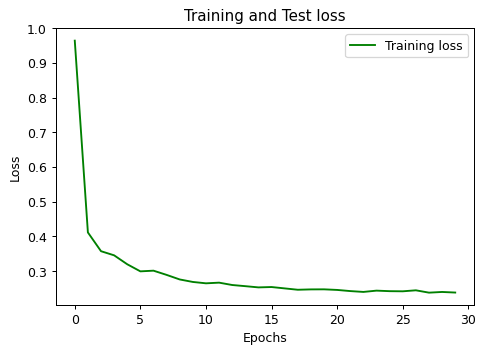

In [86]:
# Plot Training and Test loss
plt.plot(epochs_array, train_loss_array, 'g', label='Training loss')
# plt.plot(epochs_array, test_loss_array, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [87]:
# from torch.jit import load
# model = UNet()
# optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

# checkpoint = torch.load(pretrained_path)

In [88]:
# optimizer.load_state_dict(checkpoint['optimizer'])

In [89]:
# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in checkpoint['model'].items():
#     name = k[7:] # remove `module.`
#     new_state_dict[name] = v
# # load params
# model.load_state_dict(new_state_dict)

In [90]:
for i, load in enumerate(train_loader):
    img = load['image']
    mask = load['mask']
    break

In [91]:
test_path = []
tests_path = "/kaggle/input/bkai-igh-neopolyp/test/test/"
for root, dirs, files in os.walk(tests_path):
    for file in files:
        path = os.path.join(root,file)
        test_path.append(path)
len(test_path)

200

In [92]:
unet_test_dataset = UnetDataClass(test_path, normal_transform, mode = "test")
# unet_test_dataset = UNetTestDataClass(test_path, mode = "test")
test_dataloader = DataLoader(unet_test_dataset, batch_size=8, shuffle=False)

In [96]:
unet_test_dataset.__getitem__(7)[0]

{'image': tensor([[[-2.0837, -2.1179, -2.0152,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1008, -2.0837, -1.8097,  ..., -2.1179, -2.1179, -2.1179],
          [-2.0837,  0.1083, -2.0665,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-1.5357, -1.5357, -1.5357,  ..., -1.2445, -1.5699, -1.5699],
          [-1.5528, -1.5528, -1.5528,  ...,  1.7352, -1.5870, -1.5870],
          [-1.5014, -1.5014, -1.5699,  ..., -1.5357, -1.5699, -1.5699]],
 
         [[-2.0007, -2.0357, -1.9307,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0182, -2.0007, -1.7206,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0007,  0.2402, -1.9832,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-1.4230, -1.4230, -1.4230,  ..., -1.1078, -1.4405, -1.4405],
          [-1.4580, -1.4580, -1.4580,  ...,  1.9209, -1.4580, -1.4580],
          [-1.4055, -1.4055, -1.4755,  ..., -1.4580, -1.4755, -1.4755]],
 
         [[-1.7696, -1.8044, -1.6999,  ..., -1.8044, -1.8044, -1.8044],
          [-1.7870,

In [101]:
for i, (data, path, h, w) in enumerate(test_dataloader):
    img = data['image']
    break

In [102]:
model.eval()
def mask2rgb(mask):
    color_dict = {0: torch.tensor([0, 0, 0]),
                  1: torch.tensor([1, 0, 0]),
                  2: torch.tensor([0, 1, 0])}
    output = torch.zeros((mask.shape[0], mask.shape[1], 3)).long()
    for k in color_dict.keys():
        output[mask.long() == k] = color_dict[k]
    return output.to(mask.device)

if not os.path.isdir("/kaggle/working/predicted_masks"):
    os.mkdir("/kaggle/working/predicted_masks")
for _, (img, path, H, W) in enumerate(test_dataloader):
    a = path
    b = img['image']
    h = H
    w = W
    
    with torch.no_grad():
        predicted_mask = model(b)
    for i in range(len(a)):
        image_id = a[i].split('/')[-1].split('.')[0]
        filename = image_id + ".png"
        argmax = torch.argmax(predicted_mask[i], 0)
        one_hot = mask2rgb(argmax).float().permute(2, 0, 1)
        mask2img = Resize((H[i].item(), W[i].item()), interpolation=InterpolationMode.NEAREST)(ToPILImage()(one_hot))
#         mask2img = Resize((h[i].item(), w[i].item()), interpolation=InterpolationMode.NEAREST)(ToPILImage()(F.one_hot(torch.argmax(predicted_mask[i], 0)).permute(2, 0, 1).float()))
        mask2img.save(os.path.join("/kaggle/working/predicted_masks/", filename))

In [103]:
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 0] = 255
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/predicted_masks' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']
df.to_csv(r'submission.csv', index=False)

/kaggle/working/predicted_masks/5664c1711b62f15ec83b97bb11e8e0c4.png
/kaggle/working/predicted_masks/df8e26031fbb5e52c41545ba55aadaa7.png
/kaggle/working/predicted_masks/c41545ba55aadaa77712a48e11d579d9.png
/kaggle/working/predicted_masks/e4a17af18f72c8e6166a915669c99390.png
/kaggle/working/predicted_masks/2d9e593b6be1ac29adbe86f03d900fd1.png
/kaggle/working/predicted_masks/7936140a2d5fc1443c4e445927738677.png
/kaggle/working/predicted_masks/692195f853af7f8a4df1ec859759b7c8.png
/kaggle/working/predicted_masks/be86f03d900fd197cd955fa095f97845.png
/kaggle/working/predicted_masks/41ed86e58224cb76a67d4dcf9596154e.png
/kaggle/working/predicted_masks/936de314f2d95e6c487ffa651b477422.png
/kaggle/working/predicted_masks/05b78a91391adc0bb223c4eaf3372eae.png
/kaggle/working/predicted_masks/e2cd066b9fdbc3bbc04a3afe1f119f21.png
/kaggle/working/predicted_masks/2a365b5574868eb60861ee1ff0b8a4f6.png
/kaggle/working/predicted_masks/63b8318ecf467d7ad048df39beb17636.png
/kaggle/working/predicted_masks/82